In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import json
import seaborn as sns
import warnings
from urllib.request import urlopen
from plotly import graph_objects as go
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from dotenv import load_dotenv




In [2]:
load_dotenv()

True

In [3]:
Sub_National_Energy_Consumption_1 = os.getenv('Sub_National_Energy_Consumption_1')
Sub_National_Gas_Consumption_2 = os.getenv('Sub_National_Gas_Consumption_2')
UK_Population_3 = os.getenv('UK_Population_3') 
Local_Authority_District_to_Region_4 = os.getenv('Local_Authority_District_to_Region_4') 
Domestic_Energy_Bills_5 = os.getenv('Domestic_Energy_Bills_5') 
Energy_Import_Costs_6 = os.getenv('Energy_Import_Costs_6') 
Average_Earning_7 = os.getenv('Average_Earning_7')

In [4]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
#Defining the sheet names to read from the excel
Years = [str(n) for n in list(range(2005,2023))]

#Defining the dataframe which will hold the Energy consumption data as the concatination of sheets in the excel with the Year appended
Energy_Consumption = pd.concat(((pd.read_excel(io=Sub_National_Energy_Consumption_1, sheet_name=Year, header=5, nrows=11, skiprows=[6,7,8,9,10,18,19]).assign(Year = Year))for Year in Years), ignore_index=True)
Energy_Consumption['Country or region'].unique()

array(['North East', 'North West', 'Yorkshire and The Humber',
       'East Midlands', 'West Midlands', 'East', 'London', 'South East',
       'South West'], dtype=object)

In [6]:
#Getting the sum of energy used in England for each year
Total_Energy_Consumption = Energy_Consumption.groupby('Year').sum()

#Rename the column for improved readability
Total_Energy_Consumption.rename(columns= {'All fuels:\nTotal': 'Total Energy Consumption (ktoe)'},inplace=True)
Total_Energy_Consumption['Total Energy Consumption (GWh)'] = Total_Energy_Consumption['Total Energy Consumption (ktoe)'] * 11.63
Total_Energy_Consumption[['Total Energy Consumption (GWh)','Total Energy Consumption (ktoe)']]

,Total Energy Consumption (GWh),Total Energy Consumption (ktoe)
Year,,
2005,1.477577e+06,127048.781758
2006,1.440840e+06,123889.897740
2007,1.417789e+06,121907.900523
2008,1.364505e+06,117326.330106
2009,1.294634e+06,111318.450564
2010,1.306030e+06,112298.362641
2011,1.257540e+06,108128.997039
2012,1.252130e+06,107663.825360
2013,1.236627e+06,106330.742765


In [7]:
#For this datasource not all the sheets have the same format, so the read_excel function must be adjusted for each.

#Defining the sheet names to read from the excel
Years1 = [str(n) for n in list(range(2005,2014))]
Gas_Consumption1 = pd.concat(((pd.read_excel(io=Sub_National_Gas_Consumption_2, sheet_name=Year, header=5, nrows=9, skiprows=[6,7]).assign(Year = Year))for Year in Years1), ignore_index=True)

#In this one Inner and outerlondon are differinciated
Years2 = [str(n) for n in list(range(2014,2015))]
Gas_Consumption2 = pd.concat(((pd.read_excel(io=Sub_National_Gas_Consumption_2, sheet_name=Year, header=5, nrows=10, skiprows=[6,7]).assign(Year = Year))for Year in Years2), ignore_index=True)

#Removing the sub regions of Inner and outer London as as sum of these 'London is already included' this is to avoid double counting
Years3 = [str(n) for n in list(range(2015,2023))]
Gas_Consumption3 = pd.concat(((pd.read_excel(io=Sub_National_Gas_Consumption_2, sheet_name=Year, header=5, nrows=11, skiprows=[6,7,8,16,17]).assign(Year = Year))for Year in Years3), ignore_index=True)


#Combined data from all sheets into one dataframe
Gas_Consumption = pd.concat([Gas_Consumption1, Gas_Consumption2, Gas_Consumption3])


In [8]:
#Getting the sum of gas used in England for each year
Total_Gas_Consumption = Gas_Consumption.groupby('Year').sum()

#Rename the column for improved readability
Total_Gas_Consumption.rename(columns= {'Total consumption\n(GWh):\nAll meters': 'Total Gas Consumption (GWh)'},inplace=True)
Total_Gas_Consumption['Total Gas Consumption (GWh)'] 

Year
2005    571884.940304
2006    537493.963018
2007    523183.686839
2008    499308.585633
2009    458351.437002
2010    460366.820221
2011    436641.855643
2012    433035.246141
2013    424176.434549
2014    426286.006022
2015    414952.969360
2016    412096.411620
2017    424670.572211
2018    427583.693925
2019    426309.929563
2020    436137.014968
2021    422110.562024
2022    380574.844003
Name: Total Gas Consumption (GWh), dtype: float64

In [9]:
#Joining the Energy and Gas consumption by Year dataframes together
Energy_Gas_Consumption_Combined = pd.merge(Total_Energy_Consumption,Total_Gas_Consumption, how ='left', on=['Year','Year'])

#Calculating the percentage of total energy consumption gas consumption makes up
Energy_Gas_Consumption_Combined['Gas_Consumption_as_Percent'] = Energy_Gas_Consumption_Combined['Total Gas Consumption (GWh)']/Energy_Gas_Consumption_Combined['Total Energy Consumption (GWh)']*100
Energy_Gas_Consumption_Combined['Other_Consumption_as_Percent'] = 100 - Energy_Gas_Consumption_Combined['Gas_Consumption_as_Percent']
#fixing the year index
Energy_Gas_Consumption_Combined = Energy_Gas_Consumption_Combined.reset_index(names=['Year_x','Year'])
Energy_Gas_Consumption_Combined = Energy_Gas_Consumption_Combined.drop(columns='Year_x', axis=0)

#Printing the dataframe columns which will be plotted
Energy_Gas_Consumption_Combined[['Year', 'Total Energy Consumption (GWh)','Total Gas Consumption (GWh)','Gas_Consumption_as_Percent','Other_Consumption_as_Percent']]


,Year,Total Energy Consumption (GWh),Total Gas Consumption (GWh),Gas_Consumption_as_Percent,Other_Consumption_as_Percent
0,2005,1.477577e+06,571884.940304,38.704231,61.295769
1,2006,1.440840e+06,537493.963018,37.304222,62.695778
2,2007,1.417789e+06,523183.686839,36.901382,63.098618
3,2008,1.364505e+06,499308.585633,36.592648,63.407352
4,2009,1.294634e+06,458351.437002,35.403951,64.596049
5,2010,1.306030e+06,460366.820221,35.249331,64.750669
6,2011,1.257540e+06,436641.855643,34.721899,65.278101
7,2012,1.252130e+06,433035.246141,34.583881,65.416119
8,2013,1.236627e+06,424176.434549,34.301094,65.698906
9,2014,1.246193e+06,426286.006022,34.207054,65.792946


In [10]:
Energy_Consumption_Fig = px.line(Energy_Gas_Consumption_Combined, x='Year', y=['Total Energy Consumption (GWh)','Total Gas Consumption (GWh)'])

Energy_Consumption_Fig.update_layout(
    title="Energy Consumption in the UK by year (GWh)",
    xaxis_title="Year",
    yaxis_title="Energy Consumption (GWh)",
    title_x=0.5, 
    legend=dict(
        orientation="h", 
        yanchor="bottom", 
        y=0.88, 
        xanchor="center",  
        x=0.5,
        title = None
    ),
    height = 700,
    font=dict(
        size=26 
    )
)

Energy_Consumption_Fig

In [11]:
Gas_Consumption_as_Percentage_for_Chart = Energy_Gas_Consumption_Combined[['Year','Gas_Consumption_as_Percent','Other_Consumption_as_Percent']]
Gas_Consumption_as_Percentage_for_Chart = Gas_Consumption_as_Percentage_for_Chart.set_index('Year')
#Gas_Consumption_as_Percentage_for_Chart
#Gas_Proportion_Fig = Gas_Consumption_as_Percentage_for_Chart.plot(kind = 'bar', stacked = True )
Gas_Consumption_as_Percentage_for_Chart_Bar = px.bar(Gas_Consumption_as_Percentage_for_Chart)
Gas_Consumption_as_Percentage_for_Chart_Bar.update_layout(
    margin={"r": 10, "t": 140, "l": 10, "b": 10},
    title='Gas as a Portion of Total Energy Consumption',
    xaxis_title="Year",
    yaxis_title="Percentage Consumption (%)",
    title_x=0.5,
    legend=dict(
        orientation="h", 
        yanchor="bottom", 
        y=1, 
        xanchor="center",  
        x=0.5,
        title = None
    ),
    height = 700,
    font=dict(
        size=26 
    ))



The Importation of Population Data

In [12]:
#The Importation of Population Data

#Source for this data it's the 'Mid-2011 to mid-2022 edition of this dataset'
#https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland

UK_Population_Raw_Data = pd.read_excel(io=UK_Population_3,sheet_name='MYEB1', header=1)
UK_Population_Raw_Data

,ladcode23,laname23,country,sex,age,population_2011,population_2012,population_2013,population_2014,population_2015,population_2016,population_2017,population_2018,population_2019,population_2020,population_2021,population_2022
0,E06000001,Hartlepool,E,F,0,555,565,508,513,517,507,508,463,495,455,446,430
1,E06000001,Hartlepool,E,F,1,584,557,561,506,515,522,526,501,462,498,477,461
2,E06000001,Hartlepool,E,F,2,561,570,565,556,509,518,521,516,527,459,506,489
3,E06000001,Hartlepool,E,F,3,565,567,578,564,552,532,534,523,531,522,463,512
4,E06000001,Hartlepool,E,F,4,546,552,557,582,564,557,530,538,514,520,523,468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65697,W06000024,Merthyr Tydfil,W,M,86,62,58,56,75,81,66,74,71,74,63,85,84
65698,W06000024,Merthyr Tydfil,W,M,87,46,55,43,46,64,69,61,63,62,58,54,76
65699,W06000024,Merthyr Tydfil,W,M,88,48,36,46,35,39,55,61,61,56,55,50,50
65700,W06000024,Merthyr Tydfil,W,M,89,32,44,33,41,27,31,46,49,52,43,50,44


In [13]:
UK_Population_Raw_Data[UK_Population_Raw_Data['laname23']== '']

,ladcode23,laname23,country,sex,age,population_2011,population_2012,population_2013,population_2014,population_2015,population_2016,population_2017,population_2018,population_2019,population_2020,population_2021,population_2022


In [14]:
#Source for Lookup table:
#https://geoportal.statistics.gov.uk/datasets/ons::local-authority-district-to-region-april-2020-lookup-in-en/explore
#In excel Find and replace was used to change all instances of 'East of England' to 'East'
LAD20_to_RGN20_Conversion_Table = pd.read_excel(io=Local_Authority_District_to_Region_4)
LAD20_to_RGN20_Conversion_Table

,LAD20CD,LAD20NM,RGN20CD,RGN20NM,FID
0,E06000012,North East Lincolnshire,E12000003,Yorkshire and The Humber,1.0
1,E06000013,North Lincolnshire,E12000003,Yorkshire and The Humber,2.0
2,E06000014,York,E12000003,Yorkshire and The Humber,3.0
3,E07000163,Craven,E12000003,Yorkshire and The Humber,4.0
4,E07000164,Hambleton,E12000003,Yorkshire and The Humber,5.0
...,...,...,...,...,...
315,E06000062,NaN,NaN,South East,NaN
316,E06000063,NaN,NaN,South East,NaN
317,E06000064,NaN,NaN,South East,NaN
318,E06000065,NaN,NaN,South East,NaN


In [15]:
LAD20_to_RGN20_Conversion_Table['RGN20NM'].unique()


array(['Yorkshire and The Humber', 'East Midlands', 'North East',
       'North West', 'London', 'South East', 'West Midlands',
       'South West', 'East'], dtype=object)

In [16]:
#Join the RGN20NM onto the UK_Population_Density_Raw_Data table
UK_Population_Raw_Data_With_Region = pd.merge(UK_Population_Raw_Data, LAD20_to_RGN20_Conversion_Table, left_on='ladcode23', right_on='LAD20CD', how='left')

#This checks if all rows relating to england have had a RGN20NM successfully allocated
len(UK_Population_Raw_Data_With_Region[UK_Population_Raw_Data_With_Region['RGN20NM'].notna()]) - len(UK_Population_Raw_Data_With_Region[UK_Population_Raw_Data_With_Region['country'] == 'E'])

#This initially returned a difference of 1092
#After manual adjustments this turned to 0

0

In [17]:
Region_Allocation_Erros = UK_Population_Raw_Data_With_Region[
    (UK_Population_Raw_Data_With_Region['RGN20NM'].isna()) &
    (UK_Population_Raw_Data_With_Region['country'] == 'E')]

Region_Allocation_Erros['ladcode23'].unique()

#The output here initially was: 'array(['E06000061', 'E06000062', 'E06000063', 'E06000064', 'E06000065', 'E06000066'], dtype=object)'
#These values where allocated manually in the LAD20_to_RGN20_Conversion_Table excel. The the join was performed again.


array([], dtype=object)

In [18]:
#Group by Region
Population_by_Region_Pivoted = UK_Population_Raw_Data_With_Region.groupby('RGN20NM',as_index=False).agg({
    'population_2011' : 'sum',
    'population_2012' : 'sum',
    'population_2013' : 'sum',
    'population_2014' : 'sum',
    'population_2015' : 'sum',
    'population_2016' : 'sum',
    'population_2017' : 'sum',
    'population_2018' : 'sum',
    'population_2019' : 'sum',
    'population_2020' : 'sum',
    'population_2021' : 'sum',
    'population_2022' : 'sum',
})

Population_by_Region_Pivoted


,RGN20NM,population_2011,population_2012,population_2013,population_2014,population_2015,population_2016,population_2017,population_2018,population_2019,population_2020,population_2021,population_2022
0,East,5862418,5915033,5970484,6039521,6098262,6161075,6202843,6237376,6274179,6297779,6349646,6401418
1,East Midlands,3843481,3867559,3893081,3920956,3948451,3984949,4018910,4045911,4066985,4076473,4094434,4142077
2,London,8204407,8320767,8438987,8547192,8659545,8743651,8776229,8833335,8889743,8867008,8804769,8869043
3,North East,2596441,2598972,2603299,2610482,2611804,2618253,2623787,2629393,2636676,2637426,2647493,2682069
4,North West,6556144,6580509,6607066,6642793,6683933,6735195,6777072,6817175,6864096,6882166,6923363,7012739
5,South East,10979355,11073623,11162565,11261890,11354048,11459199,11529391,11588320,11645604,11679917,11775410,11884007
6,South West,4769250,4800501,4835318,4877847,4922695,4972176,5015771,5047542,5077805,5095680,5139722,5189846
7,West Midlands,5608667,5640325,5676945,5716882,5756287,5812248,5855052,5889328,5920977,5931924,5956226,6017026
8,Yorkshire and The Humber,4687006,4709523,4730941,4752756,4773651,4802288,4820493,4836148,4853991,4857588,4863828,4914317


In [19]:
#Unpivot the year columns

Population_by_Region_and_Year = pd.melt(Population_by_Region_Pivoted, id_vars='RGN20NM')
Population_by_Region_and_Year = Population_by_Region_and_Year.rename(columns={'RGN20NM':'Region','variable':'Year','value':'Population'})
Population_by_Region_and_Year['Year'] = Population_by_Region_and_Year['Year'].apply(lambda x: x.split('_')[1])

Population_by_Region_and_Year

,Region,Year,Population
0,East,2011,5862418
1,East Midlands,2011,3843481
2,London,2011,8204407
3,North East,2011,2596441
4,North West,2011,6556144
...,...,...,...
103,North West,2022,7012739
104,South East,2022,11884007
105,South West,2022,5189846
106,West Midlands,2022,6017026


In [20]:
Population_by_Region_and_Year_Line = px.line(Population_by_Region_and_Year, x= 'Year', y='Population', color='Region')

Population_by_Region_and_Year_Line
Population_by_Region_and_Year_Line.update_layout(
        margin={"r": 10, "t": 170, "l": 10, "b": 10},
    title="Population by Region and Year",
    xaxis_title="Year",
    yaxis_title="Population",
    title_x=0.5,
    title_y=0.95, 
    legend=dict(
        orientation="h", 
        yanchor="bottom", 
        y=1, 
        xanchor="center",  
        x=0.5,
        title = None
    ,font=dict(
        size=26 
    )),
    height = 1000,
    font=dict(
        size=26 
    ))
    
Population_by_Region_and_Year_Line


In [21]:
Population_by_Region_and_Year_Pivot = Population_by_Region_and_Year.pivot(index = 'Year', columns= 'Region')
Population_by_Region_and_Year_Pivot['Year'] = Population_by_Region_and_Year_Pivot.index
Population_by_Region_and_Year_Pivot.corr()

#High corrolation with Year so exterapolation is viable

Population                          \
Region                                    East East Midlands    London   
           Region                                                        
Population East                       1.000000      0.995639  0.952173   
           East Midlands              0.995639      1.000000  0.936214   
           London                     0.952173      0.936214  1.000000   
           North East                 0.920096      0.937375  0.786523   
           North West                 0.984919      0.994076  0.895828   
           South East                 0.999387      0.996868  0.943988   
           South West                 0.997129      0.998976  0.931793   
           West Midlands              0.996699      0.999739  0.942203   
           Yorkshire and The Humber   0.994990      0.997280  0.945407   
Year                                  0.992994      0.995321  0.917723   

                                                                      \
Region                              North East North West South East   
           Region                                                      
Population East                       0.920096   0.984919   0.999387   
           East Midlands              0.937375   0.994076   0.996868   
           London                     0.786523   0.895828   0.943988   
           North East                 1.000000   0.963696   0.931897   
           North West                 0.963696   1.000000   0.988930   
           South East                 0.931897   0.988930   1.000000   
           South West                 0.937396   0.994409   0.998226   
           West Midlands              0.931297   0.992083   0.997300   
           Yorkshire and The Humber   0.940663   0.989665   0.996488   
Year                                  0.939365   0.994604   0.994499   

                                                              \
Region                              South West West Midlands   
           Region                                              
Population East                       0.997129      0.996699   
           East Midlands              0.998976      0.999739   
           London                     0.931793      0.942203   
           North East                 0.937396      0.931297   
           North West                 0.994409      0.992083   
           South East                 0.998226      0.997300   
           South West                 1.000000      0.998837   
           West Midlands              0.998837      1.000000   
           Yorkshire and The Humber   0.995347      0.997378   
Year                                  0.997157      0.994335   

                                                                  Year  
Region                              Yorkshire and The Humber            
           Region                                                       
Population East                                     0.994990  0.992994  
           East Midlands                            0.997280  0.995321  
           London                                   0.945407  0.917723  
           North East                               0.940663  0.939365  
           North West                               0.989665  0.994604  
           South East                               0.996488  0.994499  
           South West                               0.995347  0.997157  
           West Midlands                            0.997378  0.994335  
           Yorkshire and The Humber                 1.000000  0.989635  
Year                                                0.989635  1.000000

In [22]:
def extrapolate_population_for_region_v1(region):
    #Filtering to handle each region seperately
    Population_by_Region_and_Year_for_Extrapoloation = Population_by_Region_and_Year[Population_by_Region_and_Year['Region']==region]

    X = Population_by_Region_and_Year_for_Extrapoloation['Year'].values.reshape(-1,1)
    y = Population_by_Region_and_Year_for_Extrapoloation['Population']

    #Fitting the linear regession model
    Population_by_Region_and_Year_Model = LinearRegression()
    Population_by_Region_and_Year_Model.fit(X,y)
    
    #Extrapolating for the years where data is missing
    years_to_extrapolate = np.array([2005, 2006, 2007, 2008, 2009, 2010]).reshape(-1, 1)

    population_predictions = Population_by_Region_and_Year_Model.predict(years_to_extrapolate)
    population_predictions = population_predictions.astype(int)
    
    #Bring the predictions into a dataframe
    Predictions_df = pd.DataFrame({'Year':years_to_extrapolate.flatten(),'Population':Population_by_Region_and_Year_Model.predict(years_to_extrapolate),'Region':region,'Data_Type': 'Extrapolated'})
    
    return Predictions_df

In [23]:
Population_by_Region_and_Year['Data_Type'] = "Origional"

In [24]:
#Create a list of regions for which to loop the extrapolate function
Regions = list(Population_by_Region_and_Year['Region'].unique())

#Concatating all the extrapolated values into one dataframe
Population_by_Region_and_Year_Extrapolated = pd.concat((extrapolate_population_for_region_v1(region) for region in Regions), ignore_index=True)

#Combining the origional data with the extrapolated data
Population_by_Region_and_Year_Combined = pd.concat([Population_by_Region_and_Year,Population_by_Region_and_Year_Extrapolated], ignore_index=True)


In [25]:
# Change the datatype of the Year column to be integer (required step to fix later graph)
Population_by_Region_and_Year_Combined['Year'] = Population_by_Region_and_Year_Combined['Year'].astype(int)

Population_by_Region_and_Year_Combined = Population_by_Region_and_Year_Combined.sort_values(by='Year')

In [26]:
Population_by_Region_and_Year_Combined[Population_by_Region_and_Year_Combined['Region'] =="Yorkshire and The Humber"]

,Region,Year,Population,Data_Type
156,Yorkshire and The Humber,2005,4.579557e+06,Extrapolated
157,Yorkshire and The Humber,2006,4.598744e+06,Extrapolated
158,Yorkshire and The Humber,2007,4.617932e+06,Extrapolated
159,Yorkshire and The Humber,2008,4.637119e+06,Extrapolated
160,Yorkshire and The Humber,2009,4.656306e+06,Extrapolated
161,Yorkshire and The Humber,2010,4.675493e+06,Extrapolated
8,Yorkshire and The Humber,2011,4.687006e+06,Origional
17,Yorkshire and The Humber,2012,4.709523e+06,Origional
26,Yorkshire and The Humber,2013,4.730941e+06,Origional
35,Yorkshire and The Humber,2014,4.752756e+06,Origional


In [27]:
Population_by_Region_and_Year_Combined_Line = px.line(Population_by_Region_and_Year_Combined, x= 'Year', y='Population', color='Region')

Population_by_Region_and_Year_Combined_Line
Population_by_Region_and_Year_Combined_Line.update_layout(
        margin={"r": 10, "t": 170, "l": 10, "b": 10},
    title="Population by Region and Year (Extrapolation Model 1)",
    xaxis_title="Year",
    yaxis_title="Population",
    title_x=0.5,
    title_y=0.95, 
    legend=dict(
        orientation="h", 
        yanchor="bottom", 
        y=1, 
        xanchor="center",  
        x=0.5,
        title = None
    ,font=dict(
        size=26 
    )),
    height = 1000,
    font=dict(
        size=26 
    ))

#Include commentry about the 2010 prediction for London this seems unlikely

In [28]:
#Lets check the R^2 value for this way of modeling

In [29]:
def extrapolate_population_for_region_r2_model1(region):
    #Filtering to handle each region seperately
    Population_by_Region_and_Year_Region = Population_by_Region_and_Year[Population_by_Region_and_Year['Region']==region]

    X = Population_by_Region_and_Year_Region['Year'].values.reshape(-1,1)
    y = Population_by_Region_and_Year_Region['Population']

    #Fitting the linear regession model
    Population_by_Region_and_Year_Model = LinearRegression()
    Population_by_Region_and_Year_Model.fit(X,y)
    
    R2 = Population_by_Region_and_Year_Model.score(X, y)
    
    return R2

In [30]:
def extrapolate_population_for_region_r2_model2(region):
    #Filtering to handle each region seperately
    Population_by_Region_and_Year_Region = Population_by_Region_and_Year[(Population_by_Region_and_Year['Region']==region) &
                                                                            (Population_by_Region_and_Year['Year']!='2020') & 
                                                                            (Population_by_Region_and_Year['Year']!='2021') &
                                                                            (Population_by_Region_and_Year['Year']!='2022')]
    
    X = Population_by_Region_and_Year_Region['Year'].values.reshape(-1,1)
    y = Population_by_Region_and_Year_Region['Population']

    #Fitting the linear regession model
    Population_by_Region_and_Year_Model = LinearRegression()
    Population_by_Region_and_Year_Model.fit(X,y)
    
    R2 = Population_by_Region_and_Year_Model.score(X, y)
    
    return R2

In [31]:
R2_outcomes = pd.DataFrame(columns=['Region','Model1_R2','Model2_R2'])

In [32]:
for region in Regions:
    new_row_for_r2 = pd.DataFrame({'Region': [region],'Model1_R2':[extrapolate_population_for_region_r2_model1(region)],'Model2_R2':[extrapolate_population_for_region_r2_model2(region)]})
    R2_outcomes = pd.concat([R2_outcomes, new_row_for_r2], ignore_index=True)
    
R2_outcomes

,Region,Model1_R2,Model2_R2
0,East,0.986038,0.989760
1,East Midlands,0.990663,0.996692
2,London,0.842216,0.967706
3,North East,0.882407,0.986730
4,North West,0.989237,0.990682
5,South East,0.989027,0.991894
6,South West,0.994322,0.996009
7,West Midlands,0.988701,0.996162
8,Yorkshire and The Humber,0.979378,0.996405


In [33]:
R2_outcomes['Percentage_Improved'] = (R2_outcomes['Model2_R2'] / R2_outcomes['Model1_R2'] - 1)*100
R2_outcomes

,Region,Model1_R2,Model2_R2,Percentage_Improved
0,East,0.986038,0.989760,0.377469
1,East Midlands,0.990663,0.996692,0.608602
2,London,0.842216,0.967706,14.899989
3,North East,0.882407,0.986730,11.822613
4,North West,0.989237,0.990682,0.146073
5,South East,0.989027,0.991894,0.289901
6,South West,0.994322,0.996009,0.169629
7,West Midlands,0.988701,0.996162,0.754630
8,Yorkshire and The Humber,0.979378,0.996405,1.738566


In [34]:
def extrapolate_population_for_region_v2(region):
    #Filtering to handle each region seperately
    Population_by_Region_and_Year_for_Extrapoloation2 = Population_by_Region_and_Year[(Population_by_Region_and_Year['Region']==region) &
                                                                            (Population_by_Region_and_Year['Year']!='2020') & 
                                                                            (Population_by_Region_and_Year['Year']!='2021') &
                                                                            (Population_by_Region_and_Year['Year']!='2022')]


    X = Population_by_Region_and_Year_for_Extrapoloation2['Year'].values.reshape(-1,1)
    y = Population_by_Region_and_Year_for_Extrapoloation2['Population']

    #Fitting the linear regession model
    Population_by_Region_and_Year_Model_v2 = LinearRegression()
    Population_by_Region_and_Year_Model_v2.fit(X,y)
    
    #Extrapolating for the years where data is missing
    years_to_extrapolate = np.array([2005, 2006, 2007, 2008, 2009, 2010]).reshape(-1, 1)

    population_predictions = Population_by_Region_and_Year_Model_v2.predict(years_to_extrapolate)
    population_predictions = population_predictions.astype(int)
    
    #Bring the predictions into a dataframe
    Predictions_df = pd.DataFrame({'Year':years_to_extrapolate.flatten(),'Population':Population_by_Region_and_Year_Model_v2.predict(years_to_extrapolate),'Region':region,'Data_Type': 'Extrapolated'})
    
    return Predictions_df

In [35]:
#Create a list of regions for which to loop the extrapolate function
Regions = list(Population_by_Region_and_Year['Region'].unique())

#Concatating all the extrapolated values into one dataframe
Population_by_Region_and_Year_Extrapolated_v2 = pd.concat((extrapolate_population_for_region_v2(region) for region in Regions), ignore_index=True)

#Combining the origional data with the extrapolated data
Population_by_Region_and_Year_Combined_v2 = pd.concat([Population_by_Region_and_Year,Population_by_Region_and_Year_Extrapolated_v2], ignore_index=True)


In [36]:
# Change the datatype of the Year column to be integer (required step to fix later graph)
Population_by_Region_and_Year_Combined_v2['Year'] = Population_by_Region_and_Year_Combined_v2['Year'].astype(int)

Population_by_Region_and_Year_Combined_v2 = Population_by_Region_and_Year_Combined_v2.sort_values(by='Year')

In [37]:
Population_by_Region_and_Year_Combined_v2_Line = px.line(Population_by_Region_and_Year_Combined_v2, x= 'Year', y='Population', color='Region')

Population_by_Region_and_Year_Combined_v2_Line
Population_by_Region_and_Year_Combined_v2_Line.update_layout(
        margin={"r": 10, "t": 170, "l": 10, "b": 10},
    title="Population by Region and Year (Extrapolation Model 2)",
    xaxis_title="Year",
    yaxis_title="Population",
    title_x=0.5,
    title_y=0.95, 
    legend=dict(
        orientation="h", 
        yanchor="bottom", 
        y=1, 
        xanchor="center",  
        x=0.5,
        title = None
    ,font=dict(
        size=26 
    )),
    height = 1000,
    font=dict(
        size=26 
    ))
#Include commentry about the 2010 prediction for London this seems unlikely

In [38]:
Population_by_Region_and_Year_Combined_v2[Population_by_Region_and_Year_Combined_v2['Region']=='London']

,Region,Year,Population,Data_Type
120,London,2005,7.743208e+06,Extrapolated
121,London,2006,7.829041e+06,Extrapolated
122,London,2007,7.914874e+06,Extrapolated
123,London,2008,8.000707e+06,Extrapolated
124,London,2009,8.086540e+06,Extrapolated
125,London,2010,8.172374e+06,Extrapolated
2,London,2011,8.204407e+06,Origional
11,London,2012,8.320767e+06,Origional
20,London,2013,8.438987e+06,Origional
29,London,2014,8.547192e+06,Origional


In [39]:
#Data taken from here:
#https://en.wikipedia.org/wiki/Regions_of_England See citation [28]

Regional_Areas = pd.DataFrame({'Region':['North East','North West','Yorkshire and The Humber', 'East Midlands', 'West Midlands', 'East', 'London', 'South East', 'South West'],'Area km^2':['8581','14108','15404','15624','12998','19116','1572','1972','23836']})

Regional_Areas['Area km^2'] = Regional_Areas['Area km^2'].astype(float)

In [40]:
Population_Density_by_Region = Population_by_Region_and_Year_Combined_v2.merge(Regional_Areas, on='Region', how='left')
Population_Density_by_Region['Population_Density(Persons.km^-2)'] = Population_Density_by_Region['Population'] / Population_Density_by_Region['Area km^2']
Population_Density_by_Region

,Region,Year,Population,Data_Type,Area km^2,Population_Density(Persons.km^-2)
0,East,2005,5.551186e+06,Extrapolated,19116.0,290.394745
1,North East,2005,2.564187e+06,Extrapolated,8581.0,298.821453
2,London,2005,7.743208e+06,Extrapolated,1572.0,4925.704658
3,East Midlands,2005,3.663689e+06,Extrapolated,15624.0,234.491086
4,South West,2005,4.519226e+06,Extrapolated,23836.0,189.596679
...,...,...,...,...,...,...
157,West Midlands,2022,6.017026e+06,Origional,12998.0,462.919372
158,South West,2022,5.189846e+06,Origional,23836.0,217.731415
159,East,2022,6.401418e+06,Origional,19116.0,334.872254
160,North West,2022,7.012739e+06,Origional,14108.0,497.075347


Making Chloropleths

Cite this user:
https://github.com/martinjc/UK-GeoJSON/tree/master
Cite this GeoJSON Specifically:
https://raw.githubusercontent.com/martinjc/UK-GeoJSON/refs/heads/master/json/eurostat/ew/nuts1.json

In [41]:
#Importing the GeoJSON
with urlopen('https://raw.githubusercontent.com/martinjc/UK-GeoJSON/refs/heads/master/json/eurostat/ew/nuts1.json') as response:
    Regions = json.load(response)
    

In [42]:
#Printing a list of all Regions in the GeoJSON along with their Location Code
for ref in range(len(Regions['features'])):
    print(f"{Regions['features'][ref]['properties']['NUTS112CD']} / {Regions['features'][ref]['properties']['NUTS112NM']}")

UKC / North East (England)
UKD / North West (England)
UKE / Yorkshire and The Humber
UKF / East Midlands (England)
UKG / West Midlands (England)
UKH / East of England
UKI / London
UKJ / South East (England)
UKK / South West (England
UKL / Wales


In [43]:
#Printing a list of all the Location Codes in the Gas_Consumption dataframe
Gas_Consumption['Country or region'].unique()

array(['North East', 'North West', 'Yorkshire and The Humber',
       'East Midlands', 'West Midlands', 'East', 'London', 'South East',
       'South West', 'Yorkshire and the Humber', 'Inner London',
       'Outer London'], dtype=object)

In [44]:
#Defining the Location_Code mapping table
Location_Code_List = [
    ('UKC', 'North East', 'North East'),
    ('UKD', 'North West', 'North West'),
    ('UKE', 'Yorkshire and The Humber', 'Yorkshire and The Humber'),
    ('UKE', 'Yorkshire and the Humber', 'Yorkshire and The Humber'),
    ('UKF', 'East Midlands', 'East Midlands'),
    ('UKG', 'West Midlands', 'West Midlands'),
    ('UKH', 'East', 'East'),
    ('UKI', 'Inner London', 'London'),
    ('UKI', 'Outer London', 'London'),
    ('UKI', 'London', 'London'),
    ('UKJ', 'South East', 'South East'),
    ('UKK', 'South West', 'South West')
]

Location_Code = pd.DataFrame(Location_Code_List, columns=['Location_Code', 'In_Region', 'Region'])
Location_Code

,Location_Code,In_Region,Region
0,UKC,North East,North East
1,UKD,North West,North West
2,UKE,Yorkshire and The Humber,Yorkshire and The Humber
3,UKE,Yorkshire and the Humber,Yorkshire and The Humber
4,UKF,East Midlands,East Midlands
5,UKG,West Midlands,West Midlands
6,UKH,East,East
7,UKI,Inner London,London
8,UKI,Outer London,London
9,UKI,London,London


In [45]:
#This step reclassifies regions into the desired regions found in the Geo-JSON
Gas_Consumption_Cleaned = Gas_Consumption.merge(Location_Code, right_on='In_Region', left_on='Country or region', how='left')

#This step combines values for Outer and inner london, which have both been classified as London
Gas_Consumption_Cleaned = Gas_Consumption_Cleaned.groupby(['Year','Location_Code'],as_index=False).agg({
    'Region': 'max',
    'Number of meters\n(thousands):\nDomestic\n' : 'sum',
     'Number of meters\n(thousands):\nNon-Domestic': 'sum',
     'Number of meters\n(thousands):\nAll meters': 'sum',
     'Total consumption\n(GWh):\nDomestic\n': 'sum',
     'Total consumption\n(GWh):\nNon-Domestic': 'sum',
     'Total consumption\n(GWh):\nAll meters': 'sum',
     'Mean consumption\n(kWh per meter):\nDomestic\n': 'sum',
     'Mean consumption\n(kWh per meter):\nNon-Domestic': 'sum',
     'Mean consumption\n(kWh per meter):\nAll meters' : 'sum'
})
Gas_Consumption_Cleaned

,Year,Location_Code,Region,Number of meters\n(thousands):\nDomestic\n,Number of meters\n(thousands):\nNon-Domestic,Number of meters\n(thousands):\nAll meters,Total consumption\n(GWh):\nDomestic\n,Total consumption\n(GWh):\nNon-Domestic,Total consumption\n(GWh):\nAll meters,Mean consumption\n(kWh per meter):\nDomestic\n,Mean consumption\n(kWh per meter):\nNon-Domestic,Mean consumption\n(kWh per meter):\nAll meters
0,2005,UKC,North East,1037.403,16.219,1053.622,20710.658157,13952.158200,34662.816357,19963.946660,860235.415254,32898.721132
1,2005,UKD,North West,2747.967,48.871,2796.838,53390.873953,35926.287793,89317.161746,19429.226753,735124.875550,31935.050134
2,2005,UKE,Yorkshire and The Humber,1989.970,36.997,2026.967,39024.143235,30648.965991,69673.109226,19610.417863,828417.601184,34373.085120
3,2005,UKF,East Midlands,1620.786,28.502,1649.288,31469.021304,18936.399391,50405.420695,19415.901485,664388.442601,30561.927750
4,2005,UKG,West Midlands,1984.918,36.397,2021.315,37726.189511,22962.792215,60688.981726,19006.422185,630897.937055,30024.504704
...,...,...,...,...,...,...,...,...,...,...,...,...
157,2022,UKG,West Midlands,2221.428,21.914,2243.342,25247.105176,15406.577700,40653.682876,11365.259273,703047.262016,18121.928300
158,2022,UKH,East,2217.992,20.366,2238.358,25143.154335,13711.245874,38854.400209,11335.998658,673241.965715,17358.438734
159,2022,UKI,London,3001.866,39.524,3041.390,35792.967053,19576.692142,55369.659195,11923.572555,495311.510530,18205.379512
160,2022,UKJ,South East,3428.042,35.662,3463.704,39604.299045,16541.969255,56146.268301,11553.037870,463854.221730,16209.892156


In [46]:
#Checking that all regions have been successfully allocated a Location_Code
Gas_Consumption_Cleaned[Gas_Consumption_Cleaned['Location_Code'].isnull()]

,Year,Location_Code,Region,Number of meters\n(thousands):\nDomestic\n,Number of meters\n(thousands):\nNon-Domestic,Number of meters\n(thousands):\nAll meters,Total consumption\n(GWh):\nDomestic\n,Total consumption\n(GWh):\nNon-Domestic,Total consumption\n(GWh):\nAll meters,Mean consumption\n(kWh per meter):\nDomestic\n,Mean consumption\n(kWh per meter):\nNon-Domestic,Mean consumption\n(kWh per meter):\nAll meters


In [47]:
#Converts the field 'Year' to an integer to allow following join
Gas_Consumption_Cleaned['Year'] = Gas_Consumption_Cleaned['Year'].astype(int)

In [48]:
#Here I am merging the Population density data onto the Gas energy consumption data
Gas_Consumption_Cleaned_PopD = Gas_Consumption_Cleaned.merge(Population_Density_by_Region, on=['Region','Year'], how='left')

Gas_Consumption_Cleaned_PopD[Gas_Consumption_Cleaned_PopD['Year'] == 2010]

,Year,Location_Code,Region,Number of meters\n(thousands):\nDomestic\n,Number of meters\n(thousands):\nNon-Domestic,Number of meters\n(thousands):\nAll meters,Total consumption\n(GWh):\nDomestic\n,Total consumption\n(GWh):\nNon-Domestic,Total consumption\n(GWh):\nAll meters,Mean consumption\n(kWh per meter):\nDomestic\n,Mean consumption\n(kWh per meter):\nNon-Domestic,Mean consumption\n(kWh per meter):\nAll meters,Population,Data_Type,Area km^2,Population_Density(Persons.km^-2)
45,2010,UKC,North East,1080.768,11.923,1092.691,16620.453603,9478.474684,26098.928287,15378.373160,794973.973329,23885.003434,2.589266e+06,Extrapolated,8581.0,301.744092
46,2010,UKD,North West,2833.501,34.101,2867.602,43159.855574,26673.463523,69833.319097,15231.988827,782190.068414,24352.514434,6.498146e+06,Extrapolated,14108.0,460.600117
47,2010,UKE,Yorkshire and The Humber,2083.114,25.578,2108.692,32486.133640,22541.149332,55027.282972,15594.985987,881270.988037,26095.457740,4.667718e+06,Extrapolated,15404.0,303.019842
48,2010,UKF,East Midlands,1714.820,19.904,1734.724,26448.515431,14815.583187,41264.098618,15423.493679,744352.049186,23787.126147,3.809082e+06,Extrapolated,15624.0,243.796871
49,2010,UKG,West Midlands,2068.149,24.960,2093.109,31161.449497,16743.357037,47904.806534,15067.313572,670807.573598,22886.914410,5.560093e+06,Extrapolated,12998.0,427.765291
50,2010,UKH,East,2004.529,23.978,2028.507,30751.229491,17361.387992,48112.617483,15340.875333,724054.883310,23718.240796,5.817881e+06,Extrapolated,19116.0,304.346169
51,2010,UKI,London,2987.734,44.259,3031.993,44701.219243,22721.974812,67423.194055,14961.579325,513386.538602,22237.252545,8.172374e+06,Extrapolated,1572.0,5198.710966
52,2010,UKJ,South East,3130.822,41.931,3172.753,48158.250292,21256.898786,69415.149078,15381.982844,506949.483342,21878.522872,1.091100e+07,Extrapolated,1972.0,5532.959150
53,2010,UKK,South West,1779.916,20.640,1800.556,23919.620625,11367.803472,35287.424097,13438.623297,550765.672093,19598.070872,4.721775e+06,Extrapolated,23836.0,198.094253


In [49]:
#Calculated Gas consumption per person for each region and year
Gas_Consumption_Cleaned_PopD['Domestic_Gas_Consumption(GWh/person)'] = Gas_Consumption_Cleaned_PopD['Total consumption\n(GWh):\nDomestic\n']/Gas_Consumption_Cleaned_PopD['Population']
Gas_Consumption_Cleaned_PopD['Commercial_Gas_Consumption(GWh/person)'] = Gas_Consumption_Cleaned_PopD['Total consumption\n(GWh):\nNon-Domestic']/Gas_Consumption_Cleaned_PopD['Population']
Gas_Consumption_Cleaned_PopD['Total_Gas_Consumption(GWh/person)'] = Gas_Consumption_Cleaned_PopD['Total consumption\n(GWh):\nAll meters']/Gas_Consumption_Cleaned_PopD['Population']

#Please note only domestic values where used in visualisation as the scope of this project centres around the domestic cost of energy
Gas_Consumption_Cleaned_PopD

,Year,Location_Code,Region,Number of meters\n(thousands):\nDomestic\n,Number of meters\n(thousands):\nNon-Domestic,Number of meters\n(thousands):\nAll meters,Total consumption\n(GWh):\nDomestic\n,Total consumption\n(GWh):\nNon-Domestic,Total consumption\n(GWh):\nAll meters,Mean consumption\n(kWh per meter):\nDomestic\n,Mean consumption\n(kWh per meter):\nNon-Domestic,Mean consumption\n(kWh per meter):\nAll meters,Population,Data_Type,Area km^2,Population_Density(Persons.km^-2),Domestic_Gas_Consumption(GWh/person),Commercial_Gas_Consumption(GWh/person),Total_Gas_Consumption(GWh/person)
0,2005,UKC,North East,1037.403,16.219,1053.622,20710.658157,13952.158200,34662.816357,19963.946660,860235.415254,32898.721132,2.564187e+06,Extrapolated,8581.0,298.821453,0.008077,0.005441,0.013518
1,2005,UKD,North West,2747.967,48.871,2796.838,53390.873953,35926.287793,89317.161746,19429.226753,735124.875550,31935.050134,6.300295e+06,Extrapolated,14108.0,446.576040,0.008474,0.005702,0.014177
2,2005,UKE,Yorkshire and The Humber,1989.970,36.997,2026.967,39024.143235,30648.965991,69673.109226,19610.417863,828417.601184,34373.085120,4.561347e+06,Extrapolated,15404.0,296.114433,0.008555,0.006719,0.015275
3,2005,UKF,East Midlands,1620.786,28.502,1649.288,31469.021304,18936.399391,50405.420695,19415.901485,664388.442601,30561.927750,3.663689e+06,Extrapolated,15624.0,234.491086,0.008589,0.005169,0.013758
4,2005,UKG,West Midlands,1984.918,36.397,2021.315,37726.189511,22962.792215,60688.981726,19006.422185,630897.937055,30024.504704,5.356108e+06,Extrapolated,12998.0,412.071665,0.007044,0.004287,0.011331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2022,UKG,West Midlands,2221.428,21.914,2243.342,25247.105176,15406.577700,40653.682876,11365.259273,703047.262016,18121.928300,6.017026e+06,Origional,12998.0,462.919372,0.004196,0.002560,0.006756
158,2022,UKH,East,2217.992,20.366,2238.358,25143.154335,13711.245874,38854.400209,11335.998658,673241.965715,17358.438734,6.401418e+06,Origional,19116.0,334.872254,0.003928,0.002142,0.006070
159,2022,UKI,London,3001.866,39.524,3041.390,35792.967053,19576.692142,55369.659195,11923.572555,495311.510530,18205.379512,8.869043e+06,Origional,1572.0,5641.884860,0.004036,0.002207,0.006243
160,2022,UKJ,South East,3428.042,35.662,3463.704,39604.299045,16541.969255,56146.268301,11553.037870,463854.221730,16209.892156,1.188401e+07,Origional,1972.0,6026.372718,0.003333,0.001392,0.004725


In [50]:
#Setting the maximum and minimum values as variables
Max_Domestic_Gas_Consumption = Gas_Consumption_Cleaned_PopD['Domestic_Gas_Consumption(GWh/person)'].max()
Min_Domestic_Gas_Consumption = Gas_Consumption_Cleaned_PopD['Domestic_Gas_Consumption(GWh/person)'].min()

In [51]:
#defining the graphing function
def create_domestic_choropleth(year):
    fig = px.choropleth(Gas_Consumption_Cleaned_PopD.loc[Gas_Consumption_Cleaned_PopD['Year'] == year]
                        ,locations='Location_Code'
                        ,geojson=Regions
                        ,color ='Domestic_Gas_Consumption(GWh/person)'
                        ,featureidkey="properties.NUTS112CD"
                        ,hover_name='Region'
                        ,range_color = (Min_Domestic_Gas_Consumption, Max_Domestic_Gas_Consumption))
    fig.update_geos(
        fitbounds="geojson",
       # projection_scale = 100,
        visible=False,
        projection_type="orthographic" 
        )
    fig.update_layout(
    margin={"r": 0, "t": 50, "l": 0, "b": 0}, 
    title={
        'text': f"{year}",  
        'y': 0.95, 
        'x': 0.5,  
        'xanchor': 'center',
        'yanchor': 'top'},
    coloraxis_colorbar_title=None,
    coloraxis_colorbar=dict(
            len=0.8,
            thickness=15 
        ),
        width=800,
        height=650,
        font=dict(
        size=26 
    ))

    return fig

#Showing "Domestic Gas Consumption in {year} (GWh/person)"


In [52]:
#Defining the years to graph as a variable
Years_to_Graph = list(range(2005,2023))
Years_to_Graph

[2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

In [53]:
#Looping the create a gragh function for each year
#Choropleth hidden here to support GitHub upload
'''figures = [create_domestic_choropleth(year) for year in Years_to_Graph]

for fig in figures:
    fig.show()'''


'figures = [create_domestic_choropleth(year) for year in Years_to_Graph]\n\nfor fig in figures:\n    fig.show()'

This is the Importation of Energy Bills data

In [54]:
Regions

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'NUTS112CD': 'UKC', 'NUTS112NM': 'North East (England)'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-1.223182516435012, 54.62576524940428],
       [-1.22502460042248, 54.62565662180565],
       [-1.224678154166887, 54.62611902935307],
       [-1.223790361449388, 54.626297563076164],
       [-1.222828682474068, 54.62596249380343],
       [-1.223182516435012, 54.62576524940428]]],
     [[[-1.150286221421286, 54.63219587283526],
       [-1.150956081057477, 54.631943519180346],
       [-1.15128345022148, 54.632215452697515],
       [-1.150555418090481, 54.63347660679483],
       [-1.15127928801273, 54.63457269862881],
       [-1.150930001166741, 54.63520293755714],
       [-1.150497283073589, 54.63515048551132],
       [-1.149621854783148, 54.63500683683295],
       [-1.149394960059329, 54.63467094622042]

In [55]:
#The importation of Energy price data

#Importing the Historical data sheet (Pre-2020 data)
Energy_Price_Raw_S1 = pd.read_excel(io=Domestic_Energy_Bills_5, sheet_name=r'2.2.3 (Historic Consumption)', header=16, usecols='A:F')
#Filtering to only include the average value for each region for each year
Energy_Price_Raw_S1 = Energy_Price_Raw_S1[Energy_Price_Raw_S1['Bill range\n[Note 1]'] == 'Average']
#Selecting only the needed columns
Energy_Price_Raw_S1 = Energy_Price_Raw_S1[['Year', 'PES area', 'Credit: Unit cost (Pence per kWh)']]
#Renaming columns to fit with the same naming convention as the recent dataset
Energy_Price_Raw_S1.rename(columns={'PES area':'Region','Credit: Unit cost (Pence per kWh)':'Average Unit Cost (Pence per kWh)'}, inplace = True)
#Removing Yearly totals. These will be calculated later using an aggregate function
Energy_Price_Raw_S1 = Energy_Price_Raw_S1[Energy_Price_Raw_S1['Region'] != 'United Kingdom']
#(!!)Removing years later than 2017 as these are included in both datasets. Include dialog around the difference in these years. The latest dataset was chosen under the assumption that the more recent data would be better. justify this
Energy_Price_Raw_S1 = Energy_Price_Raw_S1[Energy_Price_Raw_S1['Year'] < 2017]

#Importing the Historical data sheet (Post-2018 data)
Energy_Price_Raw_S2 = pd.read_excel(io=Domestic_Energy_Bills_5, sheet_name=r'2.2.3', header=11,usecols='A:C')
#Removing Yearly totals. These will be calculated later using an aggregate function
Energy_Price_Raw_S2 = Energy_Price_Raw_S2[Energy_Price_Raw_S2['Region'] != 'United Kingdom']
Energy_Price_Raw_S2.rename(columns={'Credit: Unit cost (Pence per kWh)':'Average Unit Cost (Pence per kWh)'}, inplace = True)

Energy_Price = pd.concat([Energy_Price_Raw_S1,Energy_Price_Raw_S2])


In [56]:
Energy_Price[Energy_Price['Year'] == 2000]

,Year,Region,Average Unit Cost (Pence per kWh)
63,2000,Northern Scotland,8.25
65,2000,Northern Ireland,9.35
67,2000,West Midlands,7.44
70,2000,South East,7.38
73,2000,South Wales,8.64
76,2000,Southern Scotland,8.11
79,2000,Eastern,7.31
82,2000,Yorkshire,7.57
85,2000,Merseyside & North Wales,8.21
88,2000,London,7.64


In [57]:
#ChatGPT Generated code to replace 'South West' with the average of 'Southern' and 'South West'
# Group by Year to calculate averages
for year in Energy_Price['Year'].unique():
    # Filter the current year's data for 'Southern' and 'South West'
    southern_value = Energy_Price.loc[(Energy_Price['Year'] == year) & (Energy_Price['Region'] == 'Southern'), 'Average Unit Cost (Pence per kWh)'].values
    south_west_value = Energy_Price.loc[(Energy_Price['Year'] == year) & (Energy_Price['Region'] == 'South West'), 'Average Unit Cost (Pence per kWh)'].values

    if southern_value.size > 0 and south_west_value.size > 0:
        # Calculate the average
        avg_value = (southern_value[0] + south_west_value[0]) / 2

        # Update 'South West' value
        Energy_Price.loc[(Energy_Price['Year'] == year) & (Energy_Price['Region'] == 'South West'), 'Average Unit Cost (Pence per kWh)'] = avg_value

In [58]:
#This process above assumes that each region is of roughly the same magnitude. Interpolation was used

In [59]:
Energy_Price.rename(columns={'Region':'In_Region'}, inplace = True)

In [60]:
#Standardisation of naming convention for Region
Energy_Price['In_Region'].unique()
Energy_Price_Region_Correction = pd.DataFrame({'In_Region':['West Midlands',
       'South East', 'Eastern',
       'Yorkshire', 'London', 'North West',
       'North East', 'East Midlands', 'South West'], 'Region':['West Midlands','South East','East','Yorkshire and The Humber','London', 'North West',
       'North East', 'East Midlands', 'South West']})
Energy_Price_Region_Correction

,In_Region,Region
0,West Midlands,West Midlands
1,South East,South East
2,Eastern,East
3,Yorkshire,Yorkshire and The Humber
4,London,London
5,North West,North West
6,North East,North East
7,East Midlands,East Midlands
8,South West,South West


In [61]:
Energy_Price_Region = pd.merge(Energy_Price, Energy_Price_Region_Correction, on='In_Region', how='left')
Energy_Price_Region = Energy_Price_Region[Energy_Price_Region['Region'].notnull()]

In [62]:
#Data processing to allow for the line graph of energy price by year
Energy_Price_Aggregate = Energy_Price.groupby('Year',as_index=False).agg({'Average Unit Cost (Pence per kWh)' : 'mean'})
Energy_Price_Aggregate

,Year,Average Unit Cost (Pence per kWh)
0,1998,8.259667
1,1999,8.138333
2,2000,7.890667
3,2001,7.719667
4,2002,7.706667
5,2003,7.743434
6,2004,8.007071
7,2005,8.792929
8,2006,10.326263
9,2007,11.497499


Now to bring in the Gas inmport cost data

In [63]:
#Importation of the Price of Fuel Imports data
Energy_Generation_Imports_Raw = pd.read_excel(io=Energy_Import_Costs_6, sheet_name=r'3.2.1 (Annual real)', header=12, usecols='A:J')
Energy_Generation_Imports_Raw.rename(columns={'Major power producers: Coal (pence per kWh)\n[Note 1]':'Coal (pence per kWh)','Major power producers: Oil (pence per kWh)\n[Note 2, 3]':'Oil (pence per kWh)','Major power producers: Natural gas (pence per kWh)\n[Note 4]':'Natural Gas (pence per kWh)'}, inplace = True)
Energy_Generation_Imports_Subset = Energy_Generation_Imports_Raw[['Year','Coal (pence per kWh)', 'Oil (pence per kWh)','Natural Gas (pence per kWh)']]
Energy_Generation_Imports_Subset = Energy_Generation_Imports_Subset[Energy_Generation_Imports_Raw['Year'] >= 1998]

Energy_Generation_Imports_Subset

,Year,Coal (pence per kWh),Oil (pence per kWh),Natural Gas (pence per kWh)
8,1998,0.544375,0.774538,0.848242
9,1999,0.513870,0.911555,0.782009
10,2000,0.512963,1.273934,0.750103
11,2001,0.551299,1.220321,0.824940
12,2002,0.498163,1.289745,0.740489
13,2003,0.463550,1.555741,0.810822
14,2004,0.521652,1.395152,0.881483
15,2005,0.559014,2.172904,1.141708
16,2006,0.572821,2.314728,1.405394
17,2007,0.604027,2.120755,1.322306


In [64]:
Energy_Vs_Import_Price = Energy_Generation_Imports_Subset.merge(Energy_Price_Aggregate, on='Year')
#Energy_Vs_Import_Price['Log Unit Cost'] = np.log(Energy_Vs_Import_Price['Credit: Unit cost (Pence per kWh)'])
#Energy_Vs_Import_Price['Log Import Cost'] = np.log(Energy_Vs_Import_Price['Major power producers: Oil (pence per kWh)\n[Note 2, 3]'])
Energy_Vs_Import_Price

,Year,Coal (pence per kWh),Oil (pence per kWh),Natural Gas (pence per kWh),Average Unit Cost (Pence per kWh)
0,1998,0.544375,0.774538,0.848242,8.259667
1,1999,0.513870,0.911555,0.782009,8.138333
2,2000,0.512963,1.273934,0.750103,7.890667
3,2001,0.551299,1.220321,0.824940,7.719667
4,2002,0.498163,1.289745,0.740489,7.706667
5,2003,0.463550,1.555741,0.810822,7.743434
6,2004,0.521652,1.395152,0.881483,8.007071
7,2005,0.559014,2.172904,1.141708,8.792929
8,2006,0.572821,2.314728,1.405394,10.326263
9,2007,0.604027,2.120755,1.322306,11.497499


In [65]:
#Median Income by region and region Adjusted for inflation
Median_Income_Raw = pd.read_excel(io=Average_Earning_7, sheet_name='FT weekly pay by home region', header=4, nrows=9, skiprows=[5,6,7], usecols='B:E,G:H, J:N, P:Y, AA:AC')
Median_Income_Raw.rename(columns={'Unnamed: 1': 'Region'}, inplace=True)
Median_Income_Raw

,Region,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,North East,343.2,350.5,372.7,383.3,392.9,401.0,421.7,438.5,443.4,...,485.6,492.4,504.1,511.1,531.4,525.2,546.8,581.4,617.4,661.2
1,North West,370.2,383.2,399.7,409.5,422.0,433.7,451.3,460.0,471.0,...,491.5,502.5,514.5,529.8,555.8,558.1,578.0,604.4,653.3,696.0
2,Yorkshire and The Humber,360.0,375.5,394.9,400.0,414.9,425.6,444.3,452.6,462.5,...,480.6,498.3,502.3,520.4,540.8,539.7,568.5,594.5,634.7,674.8
3,East Midlands,369.6,385.7,398.2,412.2,425.3,430.0,450.2,460.2,469.8,...,491.0,501.5,516.7,529.9,547.5,562.5,573.4,604.3,644.1,684.1
4,West Midlands,366.0,378.9,397.2,404.7,419.9,431.1,449.8,456.8,469.2,...,492.1,507.6,517.1,535.5,550.8,551.7,581.8,615.0,657.9,689.9
5,East,415.9,431.7,453.0,456.7,469.4,479.9,499.0,509.5,523.3,...,550.6,569.5,574.9,589.4,610.2,607.6,573.4,670.0,709.5,763.5
6,London,479.9,496.3,514.7,526.7,538.9,555.9,581.5,598.2,606.4,...,620.8,631.8,654.1,670.8,699.3,714.3,728.4,766.6,804.9,853.4
7,South East,435.1,451.0,468.7,468.9,488.0,502.3,524.8,536.6,547.8,...,574.9,581.8,595.9,614.9,636.3,629.0,660.1,689.0,728.3,779.2
8,South West,367.1,383.9,400.7,406.0,422.6,432.6,451.9,460.0,468.3,...,498.3,513.4,527.0,537.6,560.9,558.9,577.3,622.0,667.5,700.8


In [66]:
# Unpivot the Median_Income_Raw df
Median_Income = pd.melt(
    Median_Income_Raw, 
    id_vars=['Region'], 
    var_name='Year',   
    value_name='Median_Income' )

#Convert the weekly income into salary
Median_Income['Salary'] = Median_Income['Median_Income']*52

In [67]:
Median_Income_by_Year = Median_Income.groupby('Year', as_index=False)['Salary'].mean()
Median_Income_by_Year

,Year,Salary
0,2002,20262.666667
1,2003,21012.044444
2,2004,21954.400000
3,2005,22348.444444
4,2006,23075.866667
5,2007,23643.244444
6,2008,24697.111111
7,2009,25262.755556
8,2010,25778.711111
9,2011,25916.222222


In [68]:
Energy_Vs_Import_Price_Sal = Energy_Vs_Import_Price.merge(Median_Income_by_Year, on=['Year'], how='left')
Energy_Vs_Import_Price_Sal = Energy_Vs_Import_Price_Sal[Energy_Vs_Import_Price_Sal['Salary'].notnull()]
Energy_Vs_Import_Price_Sal = Energy_Vs_Import_Price_Sal.reset_index()
Energy_Vs_Import_Price_Sal = Energy_Vs_Import_Price_Sal.drop(columns=['index'])
Energy_Vs_Import_Price_Sal["Salary (£'000)"] = Energy_Vs_Import_Price_Sal['Salary']/1000
Energy_Vs_Import_Price_Sal

,Year,Coal (pence per kWh),Oil (pence per kWh),Natural Gas (pence per kWh),Average Unit Cost (Pence per kWh),Salary,Salary (£'000)
0,2002,0.498163,1.289745,0.740489,7.706667,20262.666667,20.262667
1,2003,0.463550,1.555741,0.810822,7.743434,21012.044444,21.012044
2,2004,0.521652,1.395152,0.881483,8.007071,21954.400000,21.954400
3,2005,0.559014,2.172904,1.141708,8.792929,22348.444444,22.348444
4,2006,0.572821,2.314728,1.405394,10.326263,23075.866667,23.075867
5,2007,0.604027,2.120755,1.322306,11.497499,23643.244444,23.643244
6,2008,0.930995,2.456412,1.701349,13.237404,24697.111111,24.697111
7,2009,0.764055,2.256922,1.424737,13.728701,25262.755556,25.262756
8,2010,0.869646,3.485674,1.461134,13.337961,25778.711111,25.778711
9,2011,1.083788,4.321027,1.872670,14.411113,25916.222222,25.916222


In [69]:
Energy_Price_Vs_Salary_Fig = px.line(Energy_Vs_Import_Price_Sal
                                     , x='Year'
                                     , y=['Average Unit Cost (Pence per kWh)','Oil (pence per kWh)', 'Natural Gas (pence per kWh)', 'Coal (pence per kWh)' ]
                                     ,color_discrete_map= { 
                                                             
                                                                'Average Unit Cost (Pence per kWh)': 'green',
                                                                'Oil (pence per kWh)': 'purple',
                                                                'Coal (pence per kWh)': 'lightgrey',
                                                                'Natural Gas (pence per kWh)': 'lightgrey',})
Energy_Price_Vs_Salary_Fig.update_layout(
        margin={"r": 10, "t": 130, "l": 10, "b": 10},
    title="Unit Cost of Energy and Import Cost of Fuel (2002-2023)",
    xaxis_title="Year",
    yaxis_title="",
    title_x=0.5,
    title_y=0.95, 
    legend=dict(
        orientation="h", 
        yanchor="bottom", 
        y=1, 
        xanchor="center",  
        x=0.5,
        title = None
    ,font=dict(
        size=26 
    )),
    height = 700,
    font=dict(
        size=26 
    ))
#Energy_Vs_Import_Price_Fig = px.line(Energy_Vs_Import_Price, x='Year', y=['Oil (pence per kWh)','Average Unit Cost (Pence per kWh)'])
Energy_Price_Vs_Salary_Fig

In [70]:
Energy_Price_Vs_Salary_Fig = px.line(Energy_Vs_Import_Price_Sal
                                     , x='Year'
                                     , y=["Salary (£'000)",'Average Unit Cost (Pence per kWh)','Oil (pence per kWh)', 'Natural Gas (pence per kWh)', 'Coal (pence per kWh)' ]
                                     ,color_discrete_map= { 
                                                                "Salary (£'000)":'Orange',
                                                                'Average Unit Cost (Pence per kWh)': 'green',
                                                                'Oil (pence per kWh)': 'purple',
                                                                'Coal (pence per kWh)': 'lightgrey',
                                                                'Natural Gas (pence per kWh)': 'lightgrey',})
Energy_Price_Vs_Salary_Fig.update_layout(
        margin={"r": 10, "t": 170, "l": 10, "b": 10},
    title="Salary Against Unit Cost of Energy and Import Cost of Fuel (2002-2023)",
    xaxis_title="Year",
    yaxis_title="",
    title_x=0.5,
    title_y=0.95, 
    legend=dict(
        orientation="h", 
        yanchor="bottom", 
        y=1, 
        xanchor="center",  
        x=0.5,
        title = None
    ,font=dict(
        size=26 
    )),
    height = 700,
    font=dict(
        size=26 
    ))
#Energy_Vs_Import_Price_Fig = px.line(Energy_Vs_Import_Price, x='Year', y=['Oil (pence per kWh)','Average Unit Cost (Pence per kWh)'])
Energy_Price_Vs_Salary_Fig

Up next do corrolation matrixs on raw data
do a time series corrolation on the graph values


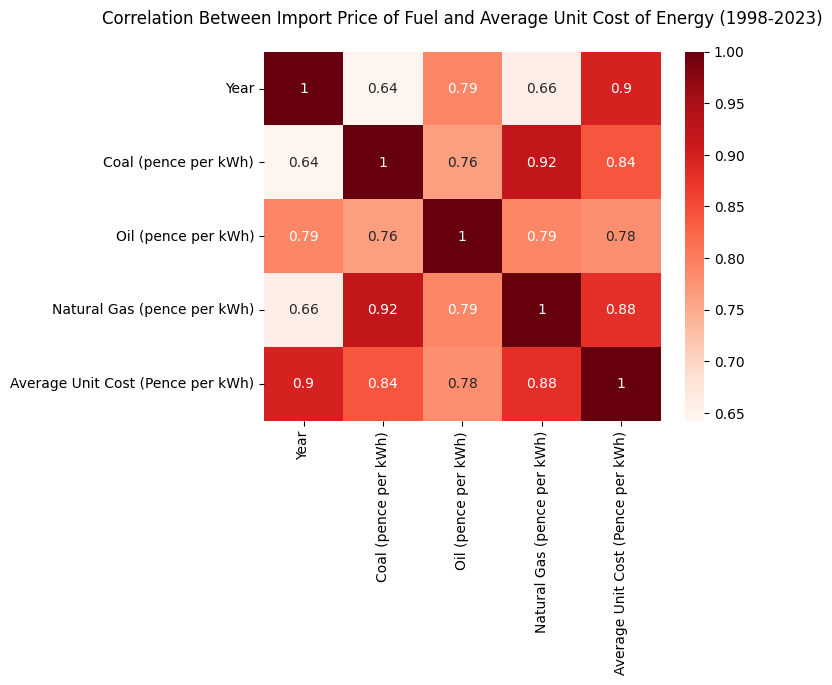

In [71]:
#Energy_Generation_Imports_Subset_Matrix = Energy_Generation_Imports_Subset.corr()
#plt.imshow(Energy_Generation_Imports_Subset_Matrix, cmap = 'Blues')
Energy_Vs_Import_Price_Matrix = Energy_Vs_Import_Price.corr()

sns.heatmap(Energy_Vs_Import_Price_Matrix, cmap="Reds", annot=True)

plt.title("Correlation Between Import Price of Fuel and Average Unit Cost of Energy (1998-2023)", pad=20)

plt.show()


In [72]:
Years_to_Graph = list(range(2005,2023))
Years_to_Graph

[2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

In [73]:
Gas_Consumption_Cleaned_PopD_MedIncome = Gas_Consumption_Cleaned_PopD.merge(Median_Income, on=['Region','Year'], how='left')
Gas_Consumption_Cleaned_PopD_MedIncome['Domestic_Gas_Consumption_to_Median_Salary(GWh/person/£)'] = Gas_Consumption_Cleaned_PopD_MedIncome['Domestic_Gas_Consumption(GWh/person)']/Gas_Consumption_Cleaned_PopD_MedIncome['Salary']
Gas_Consumption_Cleaned_PopD_MedIncome

,Year,Location_Code,Region,Number of meters\n(thousands):\nDomestic\n,Number of meters\n(thousands):\nNon-Domestic,Number of meters\n(thousands):\nAll meters,Total consumption\n(GWh):\nDomestic\n,Total consumption\n(GWh):\nNon-Domestic,Total consumption\n(GWh):\nAll meters,Mean consumption\n(kWh per meter):\nDomestic\n,...,Population,Data_Type,Area km^2,Population_Density(Persons.km^-2),Domestic_Gas_Consumption(GWh/person),Commercial_Gas_Consumption(GWh/person),Total_Gas_Consumption(GWh/person),Median_Income,Salary,Domestic_Gas_Consumption_to_Median_Salary(GWh/person/£)
0,2005,UKC,North East,1037.403,16.219,1053.622,20710.658157,13952.158200,34662.816357,19963.946660,...,2.564187e+06,Extrapolated,8581.0,298.821453,0.008077,0.005441,0.013518,383.3,19931.6,4.052304e-07
1,2005,UKD,North West,2747.967,48.871,2796.838,53390.873953,35926.287793,89317.161746,19429.226753,...,6.300295e+06,Extrapolated,14108.0,446.576040,0.008474,0.005702,0.014177,409.5,21294.0,3.979687e-07
2,2005,UKE,Yorkshire and The Humber,1989.970,36.997,2026.967,39024.143235,30648.965991,69673.109226,19610.417863,...,4.561347e+06,Extrapolated,15404.0,296.114433,0.008555,0.006719,0.015275,400.0,20800.0,4.113173e-07
3,2005,UKF,East Midlands,1620.786,28.502,1649.288,31469.021304,18936.399391,50405.420695,19415.901485,...,3.663689e+06,Extrapolated,15624.0,234.491086,0.008589,0.005169,0.013758,412.2,21434.4,4.007314e-07
4,2005,UKG,West Midlands,1984.918,36.397,2021.315,37726.189511,22962.792215,60688.981726,19006.422185,...,5.356108e+06,Extrapolated,12998.0,412.071665,0.007044,0.004287,0.011331,404.7,21044.4,3.347011e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2022,UKG,West Midlands,2221.428,21.914,2243.342,25247.105176,15406.577700,40653.682876,11365.259273,...,6.017026e+06,Origional,12998.0,462.919372,0.004196,0.002560,0.006756,615.0,31980.0,1.312053e-07
158,2022,UKH,East,2217.992,20.366,2238.358,25143.154335,13711.245874,38854.400209,11335.998658,...,6.401418e+06,Origional,19116.0,334.872254,0.003928,0.002142,0.006070,670.0,34840.0,1.127367e-07
159,2022,UKI,London,3001.866,39.524,3041.390,35792.967053,19576.692142,55369.659195,11923.572555,...,8.869043e+06,Origional,1572.0,5641.884860,0.004036,0.002207,0.006243,766.6,39863.2,1.012392e-07
160,2022,UKJ,South East,3428.042,35.662,3463.704,39604.299045,16541.969255,56146.268301,11553.037870,...,1.188401e+07,Origional,1972.0,6026.372718,0.003333,0.001392,0.004725,689.0,35828.0,9.301583e-08


In [74]:
Energy_Vs_Import_Price_Sal = Energy_Vs_Import_Price.merge(Median_Income, on=['Year'], how='left')
Energy_Vs_Import_Price_Sal

,Year,Coal (pence per kWh),Oil (pence per kWh),Natural Gas (pence per kWh),Average Unit Cost (Pence per kWh),Region,Median_Income,Salary
0,1998,0.544375,0.774538,0.848242,8.259667,NaN,NaN,NaN
1,1999,0.513870,0.911555,0.782009,8.138333,NaN,NaN,NaN
2,2000,0.512963,1.273934,0.750103,7.890667,NaN,NaN,NaN
3,2001,0.551299,1.220321,0.824940,7.719667,NaN,NaN,NaN
4,2002,0.498163,1.289745,0.740489,7.706667,North East,343.2,17846.4
...,...,...,...,...,...,...,...,...
197,2023,1.775227,4.273539,4.904535,36.700335,West Midlands,657.9,34210.8
198,2023,1.775227,4.273539,4.904535,36.700335,East,709.5,36894.0
199,2023,1.775227,4.273539,4.904535,36.700335,London,804.9,41854.8
200,2023,1.775227,4.273539,4.904535,36.700335,South East,728.3,37871.6


In [75]:
#Choropleth standardised to see if north and south are getting more or less equal
#Choropleth hidden here to support GitHub upload
'''def create_salaryration_choropleth(year):
    fig = px.choropleth(Gas_Consumption_Cleaned_PopD_MedIncome.loc[Gas_Consumption_Cleaned_PopD_MedIncome['Year'] == year]
                        ,locations='Location_Code'
                        ,geojson=Regions
                        ,color ='Domestic_Gas_Consumption_to_Median_Salary(GWh/person/£)'
                        ,featureidkey="properties.NUTS112CD"
                        ,hover_name='Region'
                        ,color_continuous_scale=px.colors.sequential.Viridis
                        )
    fig.update_geos(
        fitbounds="geojson",
       # projection_scale = 100,
        visible=False,
        projection_type="orthographic" 
        )
    fig.update_layout(
    margin={"r": 0, "t": 50, "l": 0, "b": 0}, 
    title={
        'text': f"{year}",  
        'y': 0.95, 
        'x': 0.5,  
        'xanchor': 'center',
        'yanchor': 'top'},
    coloraxis_colorbar_title=None,
    coloraxis_colorbar=dict(
            len=0.8,
            thickness=15 
        ),
        width=800,
        height=650,
        font=dict(
        size=26 
    ))

    return fig

Years_to_Graph = list(range(2005,2023))
Years_to_Graph

figures = [create_salaryration_choropleth(year) for year in Years_to_Graph]

for fig in figures:
    fig.show()
    '''
    #Showing "Domestic Gas Consumption as a Portion of Salary {year} (GWh/person/£)"

'def create_salaryration_choropleth(year):\n    fig = px.choropleth(Gas_Consumption_Cleaned_PopD_MedIncome.loc[Gas_Consumption_Cleaned_PopD_MedIncome[\'Year\'] == year]\n                        ,locations=\'Location_Code\'\n                        ,geojson=Regions\n                        ,color =\'Domestic_Gas_Consumption_to_Median_Salary(GWh/person/£)\'\n                        ,featureidkey="properties.NUTS112CD"\n                        ,hover_name=\'Region\'\n                        ,color_continuous_scale=px.colors.sequential.Viridis\n                        )\n    fig.update_geos(\n        fitbounds="geojson",\n       # projection_scale = 100,\n        visible=False,\n        projection_type="orthographic" \n        )\n    fig.update_layout(\n    margin={"r": 0, "t": 50, "l": 0, "b": 0}, \n    title={\n        \'text\': f"{year}",  \n        \'y\': 0.95, \n        \'x\': 0.5,  \n        \'xanchor\': \'center\',\n        \'yanchor\': \'top\'},\n    coloraxis_colorbar_title=None,\

In [76]:
Gas_Consumption_Cleaned_PopD_MedIncome

,Year,Location_Code,Region,Number of meters\n(thousands):\nDomestic\n,Number of meters\n(thousands):\nNon-Domestic,Number of meters\n(thousands):\nAll meters,Total consumption\n(GWh):\nDomestic\n,Total consumption\n(GWh):\nNon-Domestic,Total consumption\n(GWh):\nAll meters,Mean consumption\n(kWh per meter):\nDomestic\n,...,Population,Data_Type,Area km^2,Population_Density(Persons.km^-2),Domestic_Gas_Consumption(GWh/person),Commercial_Gas_Consumption(GWh/person),Total_Gas_Consumption(GWh/person),Median_Income,Salary,Domestic_Gas_Consumption_to_Median_Salary(GWh/person/£)
0,2005,UKC,North East,1037.403,16.219,1053.622,20710.658157,13952.158200,34662.816357,19963.946660,...,2.564187e+06,Extrapolated,8581.0,298.821453,0.008077,0.005441,0.013518,383.3,19931.6,4.052304e-07
1,2005,UKD,North West,2747.967,48.871,2796.838,53390.873953,35926.287793,89317.161746,19429.226753,...,6.300295e+06,Extrapolated,14108.0,446.576040,0.008474,0.005702,0.014177,409.5,21294.0,3.979687e-07
2,2005,UKE,Yorkshire and The Humber,1989.970,36.997,2026.967,39024.143235,30648.965991,69673.109226,19610.417863,...,4.561347e+06,Extrapolated,15404.0,296.114433,0.008555,0.006719,0.015275,400.0,20800.0,4.113173e-07
3,2005,UKF,East Midlands,1620.786,28.502,1649.288,31469.021304,18936.399391,50405.420695,19415.901485,...,3.663689e+06,Extrapolated,15624.0,234.491086,0.008589,0.005169,0.013758,412.2,21434.4,4.007314e-07
4,2005,UKG,West Midlands,1984.918,36.397,2021.315,37726.189511,22962.792215,60688.981726,19006.422185,...,5.356108e+06,Extrapolated,12998.0,412.071665,0.007044,0.004287,0.011331,404.7,21044.4,3.347011e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2022,UKG,West Midlands,2221.428,21.914,2243.342,25247.105176,15406.577700,40653.682876,11365.259273,...,6.017026e+06,Origional,12998.0,462.919372,0.004196,0.002560,0.006756,615.0,31980.0,1.312053e-07
158,2022,UKH,East,2217.992,20.366,2238.358,25143.154335,13711.245874,38854.400209,11335.998658,...,6.401418e+06,Origional,19116.0,334.872254,0.003928,0.002142,0.006070,670.0,34840.0,1.127367e-07
159,2022,UKI,London,3001.866,39.524,3041.390,35792.967053,19576.692142,55369.659195,11923.572555,...,8.869043e+06,Origional,1572.0,5641.884860,0.004036,0.002207,0.006243,766.6,39863.2,1.012392e-07
160,2022,UKJ,South East,3428.042,35.662,3463.704,39604.299045,16541.969255,56146.268301,11553.037870,...,1.188401e+07,Origional,1972.0,6026.372718,0.003333,0.001392,0.004725,689.0,35828.0,9.301583e-08


In [77]:
#Join to allow generation of choropleths displaying Energy cost againt salary by region and year
Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice = pd.merge(Gas_Consumption_Cleaned_PopD_MedIncome, Energy_Price_Region, on=['Region','Year'], how='left')
Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice["Salary (£'000)"] = Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice["Salary"]/1000
Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice["EngPrice / Salary (Pence/kWh/£'000)"] = Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice['Average Unit Cost (Pence per kWh)']/Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice["Salary (£'000)"]

In [78]:
Max_Unit_Cost = Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice["Average Unit Cost (Pence per kWh)"].max()
Min_Unit_Cost = Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice["Average Unit Cost (Pence per kWh)"].min()

In [79]:
#Choropleth showing avg energy price agianst alary by region and year (This one for comparing change over time)
#Choropleth hidden here to support GitHub upload
'''def create_salary_to_engprice_choropleth_time(year):
    fig = px.choropleth(Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice.loc[Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice['Year'] == year]
                        ,locations='Location_Code'
                        ,geojson=Regions
                        ,color ="Average Unit Cost (Pence per kWh)"
                        ,featureidkey="properties.NUTS112CD"
                        ,hover_name='Region'
                        ,range_color = (Min_Unit_Cost, Max_Unit_Cost)
                        ,color_continuous_scale = px.colors.diverging.RdYlBu[::-1]
                        )
    fig.update_geos(
        fitbounds="geojson",
       # projection_scale = 100,
        visible=False,
        projection_type="orthographic" 
        )
    fig.update_layout(
    margin={"r": 0, "t": 50, "l": 0, "b": 0}, 
    title={
        'text': f"{year}",  
        'y': 0.95, 
        'x': 0.5,  
        'xanchor': 'center',
        'yanchor': 'top'},
    coloraxis_colorbar_title=None,
    coloraxis_colorbar=dict(
            len=0.8,
            thickness=15 
        ),
        width=800,
        height=650,
        font=dict(
        size=26 
    ))

    return fig

Years_to_Graph = list(range(2005,2023))
Years_to_Graph

figures = [create_salary_to_engprice_choropleth_time(year) for year in Years_to_Graph]

for fig in figures:
    fig.show()
    
    #Showing "Average Energy Price {year} (Pence/kWh)"
    '''
    ##Do not include

'def create_salary_to_engprice_choropleth_time(year):\n    fig = px.choropleth(Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice.loc[Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice[\'Year\'] == year]\n                        ,locations=\'Location_Code\'\n                        ,geojson=Regions\n                        ,color ="Average Unit Cost (Pence per kWh)"\n                        ,featureidkey="properties.NUTS112CD"\n                        ,hover_name=\'Region\'\n                        ,range_color = (Min_Unit_Cost, Max_Unit_Cost)\n                        ,color_continuous_scale = px.colors.diverging.RdYlBu[::-1]\n                        )\n    fig.update_geos(\n        fitbounds="geojson",\n       # projection_scale = 100,\n        visible=False,\n        projection_type="orthographic" \n        )\n    fig.update_layout(\n    margin={"r": 0, "t": 50, "l": 0, "b": 0}, \n    title={\n        \'text\': f"{year}",  \n        \'y\': 0.95, \n        \'x\': 0.5,  \n        \'xanchor\'

In [80]:
Max_Price_Sal_Ratio = Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice["EngPrice / Salary (Pence/kWh/£'000)"].max()
Min_Price_Sal_Ratio = Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice["EngPrice / Salary (Pence/kWh/£'000)"].min()

In [81]:
#Choropleth showing avg energy price against salary by region and year (This one for comparing equality of north vs south)
#Choropleth hidden here to support GitHub upload
'''def create_salary_to_engprice_choropleth(year):
    fig = px.choropleth(Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice.loc[Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice['Year'] == year]
                        ,locations='Location_Code'
                        ,geojson=Regions
                        ,color ="EngPrice / Salary (Pence/kWh/£'000)"
                        ,featureidkey="properties.NUTS112CD"
                        ,hover_name='Region'
                        ,color_continuous_scale=px.colors.diverging.RdYlBu[::-1]
                        )
    fig.update_geos(
        fitbounds="geojson",
       # projection_scale = 100,
        visible=False,
        projection_type="orthographic" 
        )
    fig.update_layout(
    margin={"r": 0, "t": 50, "l": 0, "b": 0}, 
    title={
        'text': f"{year}",  
        'y': 0.95, 
        'x': 0.5,  
        'xanchor': 'center',
        'yanchor': 'top'},
    coloraxis_colorbar_title=None,
    coloraxis_colorbar=dict(
            len=0.8,
            thickness=15 
        ),
        width=800,
        height=650,
        font=dict(
        size=26 
    ))
    
    return fig

Years_to_Graph = list(range(2005,2023))
Years_to_Graph

figures = [create_salary_to_engprice_choropleth(year) for year in Years_to_Graph]

for fig in figures:
    fig.show()
    '''
    #Showsing "Average Energy Price as a Portion of Salary {year} (Pence/kWh/£'000)" (Standardised)

'def create_salary_to_engprice_choropleth(year):\n    fig = px.choropleth(Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice.loc[Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice[\'Year\'] == year]\n                        ,locations=\'Location_Code\'\n                        ,geojson=Regions\n                        ,color ="EngPrice / Salary (Pence/kWh/£\'000)"\n                        ,featureidkey="properties.NUTS112CD"\n                        ,hover_name=\'Region\'\n                        ,color_continuous_scale=px.colors.diverging.RdYlBu[::-1]\n                        )\n    fig.update_geos(\n        fitbounds="geojson",\n       # projection_scale = 100,\n        visible=False,\n        projection_type="orthographic" \n        )\n    fig.update_layout(\n    margin={"r": 0, "t": 50, "l": 0, "b": 0}, \n    title={\n        \'text\': f"{year}",  \n        \'y\': 0.95, \n        \'x\': 0.5,  \n        \'xanchor\': \'center\',\n        \'yanchor\': \'top\'},\n    coloraxis_colorbar_title

In [82]:
#Choropleth showing avg energy price agianst alary by region and year (This one for comparing change over time)
#Choropleth hidden here to support GitHub upload
'''def create_salary_to_engprice_choropleth_time(year):
    fig = px.choropleth(Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice.loc[Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice['Year'] == year]
                        ,locations='Location_Code'
                        ,geojson=Regions
                        ,color ="EngPrice / Salary (Pence/kWh/£'000)"
                        ,featureidkey="properties.NUTS112CD"
                        ,hover_name='Region'
                        ,range_color = (Min_Price_Sal_Ratio, Max_Price_Sal_Ratio)
                        ,color_continuous_scale = px.colors.diverging.RdYlBu[::-1]
                        )
    fig.update_geos(
        fitbounds="geojson",
       # projection_scale = 100,
        visible=False,
        projection_type="orthographic" 
        )
    fig.update_layout(
    margin={"r": 0, "t": 50, "l": 0, "b": 0}, 
    title={
        'text': f"{year}",  
        'y': 0.95, 
        'x': 0.5,  
        'xanchor': 'center',
        'yanchor': 'top'},
    coloraxis_colorbar_title=None,
    coloraxis_colorbar=dict(
            len=0.8,
            thickness=15 
        ),
        width=800,
        height=650,
        font=dict(
        size=26 
    ))

    return fig

Years_to_Graph = list(range(2005,2023))
Years_to_Graph

figures = [create_salary_to_engprice_choropleth_time(year) for year in Years_to_Graph]

for fig in figures:
    fig.show()
    '''
    #showing "Average Energy Price as a Portion of Salary {year} (Pence/kWh/£'000)" (on a fixed scale)

'def create_salary_to_engprice_choropleth_time(year):\n    fig = px.choropleth(Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice.loc[Gas_Consumption_Cleaned_PopD_MedIncome_EngPrice[\'Year\'] == year]\n                        ,locations=\'Location_Code\'\n                        ,geojson=Regions\n                        ,color ="EngPrice / Salary (Pence/kWh/£\'000)"\n                        ,featureidkey="properties.NUTS112CD"\n                        ,hover_name=\'Region\'\n                        ,range_color = (Min_Price_Sal_Ratio, Max_Price_Sal_Ratio)\n                        ,color_continuous_scale = px.colors.diverging.RdYlBu[::-1]\n                        )\n    fig.update_geos(\n        fitbounds="geojson",\n       # projection_scale = 100,\n        visible=False,\n        projection_type="orthographic" \n        )\n    fig.update_layout(\n    margin={"r": 0, "t": 50, "l": 0, "b": 0}, \n    title={\n        \'text\': f"{year}",  \n        \'y\': 0.95, \n        \'x\': 0.5,  \n    